# Accessing GBIF Parquet data from AWS using duckdb

In [1]:
import ibis

Let's count up species diversity across the GBIF occurrence records. As observations can be reported as longitude/latitude pairs at arbitrary precision, we can round them off to the nearest degree (or tenth of a degree, etc). This provides a convenient mechanism for aggregating occurrences into grid cells. To simplify the counting process, I will aggregate to genus (avoids a few synonyms, sub-species, and incomplete names). For now, let's also just look at vertebrates, where maybe we have some chance that sampling is closer to saturation of local diversity and we're not just looking purely at sampling effort. (That's still a bad assumption I think we'll see).

GBIF data is available in parquet partitions from the [AWS Open Data Registry](https://registry.opendata.aws/gbif/).  We use the most recent monthly snapshot, corresponding to the S3 bucket, `s3://gbif-open-data-us-east-1/occurrence/2023-02-01/occurrence.parquet/`.  `duckdb` can execute arbitrary SQL queries against this remote data source without having to first download a local copy of the data, which is around a few hundred GB at present.

While this is a natural operation for a database engine like SQL, I find SQL syntax a little cumbersome to parse for longer commands, so I'll write this in [Ibis](https://ibis-project.org/) which looks more pythonic, and let it generate the SQL under the hood.



In [2]:
con = ibis.duckdb.connect()
bucket = "gbif-open-data-us-east-1"
path = "occurrence/2023-02-01/occurrence.parquet"
gbif = con.register(f"s3://{bucket}/{path}")

In [3]:
%%time

tbl = (gbif
       .filter(gbif.phylum == "Chordata")
       .mutate(latitude = gbif.decimallatitude.round(0),
               longitude = gbif.decimallongitude.round(0))
       .select(["class", "genus", "longitude", "latitude"])
       .distinct()
       .group_by(["class","longitude", "latitude"])
       .size()
      )
#ibis.show_sql(tbl) # optionally peek at the SQL query
df = tbl.to_pandas()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

CPU times: user 16min 27s, sys: 4min 12s, total: 20min 39s
Wall time: 18min 9s


Some more detailed quality checks are definitely necessary here -- inaccurate spatial information in particular can be hugely distorting (such as museum specimens that may be tagged to the coordinates of the museum rather than their original place of origin).  Also, it is typical to use an observation model to compute likely true species richness given the observations, though with the highly varied sources and lack of effort data this is difficult (though we could imagine quite a few proxies, such as comparing to overall GBIF sampling density).  These issues are beyond our scope for the moment, which is to demonstrate a relatively simple/transparent workflow for processing the full data from the latest upstream sources.

To avoid a few oversampled locations dominating the counts I'll transform to log counts (obviously could have been done as part of our query), and focus in on a particular taxonomic Class (e.g. Amphibians).  

It would be more interesting to compare this to other data sources, such as [MoBI](https://planetarycomputer.microsoft.com/dataset/mobi) or IUCN redlist data, etc.

In [4]:
import numpy as np
taxa = df[df["class"] == "Mammalia"]

taxa = taxa.assign(logn = np.log(taxa["count"].values))
taxa


,class,longitude,latitude,count,logn
162,Mammalia,-64.0,-31.0,40,3.688879
180,Mammalia,-107.0,19.0,6,1.791759
184,Mammalia,19.0,49.0,42,3.737670
188,Mammalia,-63.0,45.0,40,3.688879
217,Mammalia,-55.0,-4.0,24,3.178054
...,...,...,...,...,...
170599,Mammalia,-148.0,73.0,1,0.000000
170600,Mammalia,99.0,-47.0,1,0.000000
170605,Mammalia,119.0,-49.0,1,0.000000
170607,Mammalia,-154.0,47.0,1,0.000000


It is natural to visualize this data as a raster with color denoting richness in each cell.  But becaues our data is generated by just rounding off observed latitudes and lognitudes, some work is required to turn this into a regular grid of fixed resolution and geographic projection which can be understood by standard spatial software. `geocube` provides a convenient higher-level interface to do this. Once we have our spatial object, we can plot the counts accordingly.


In [5]:
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

def cube(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:4326')
    geo_grid = make_geocube(
        vector_data=gdf,
        measurements=['logn'],
        resolution=1,
        rasterize_function=rasterize_points_griddata,
    )
    return geo_grid

geo_grid = cube(taxa)


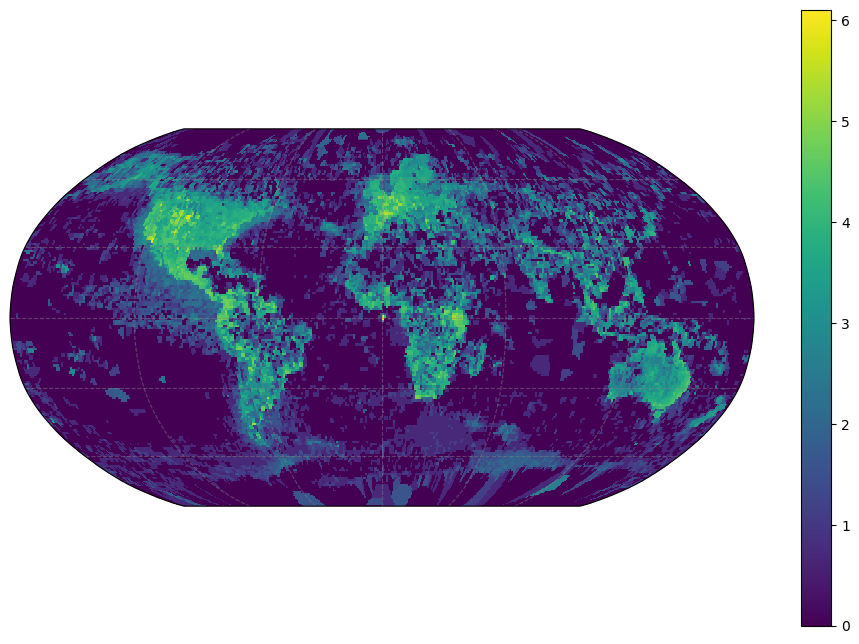

In [6]:
# plot resulting raster on global map - obviously this is more sampling bias than biodiversity
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')
plt.figure(figsize=[12,8])
p = geo_grid.logn.plot(cmap='viridis',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False)

p.axes.gridlines(color='grey', alpha=0.5, linestyle='--')

# zoom in
# p.axes.set_extent([-19, 33, 30, 66], crs=ccrs.PlateCarree())


Something of an editorial footnote here, but the raw SQL, while a bit harder to read, does seem to run faster than then the ibis-generated SQL.  Perhaps the IBIS SQL compiler's syntax is just a bit less efficient? (the dbplyr engine in R generates nearly identical syntax to this though)

In [ ]:
%%time

import duckdb
con = duckdb.connect()
con.execute("INSTALL httpfs")
con.execute("LOAD httpfs")

query = f'''
SELECT class, longitude, latitude, COALESCE(n, 0.0) AS n
FROM (
  SELECT class, longitude, latitude, COUNT(*) AS n
  FROM (
    SELECT DISTINCT
      class,
      genus,
      ROUND(decimallongitude, 0) AS longitude,
      ROUND(decimallatitude, 0) AS latitude
    FROM read_parquet("s3://gbif-open-data-us-east-1/occurrence/2023-02-01/occurrence.parquet/*")
    WHERE (phylum = 'Chordata')
  )
  GROUP BY class, longitude, latitude
)
'''

df = con.execute(query).df()